# Let's finally do this. UNet implementation.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
datadir = '/data/stephan/WeatherBench/5.625deg/'

In [5]:
var_dict = {
    'geopotential': ('z', [500]),
    'temperature': ('t', [850]),
    'constants': ['lat2d', 'orography', 'lsm']
}

In [6]:
output_vars = ['z_500', 't_850']

In [7]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])

In [8]:
ds_train = ds.sel(time=slice('2000', '2015'))
ds_valid = ds.sel(time=slice('2016', '2016'))
ds_test = ds.sel(time=slice('2017', '2018'))

In [9]:
lead_time=72
filters = [128, 128, 128, 128, 128, 128, 2]
kernels = [5, 5, 5, 5, 5, 5, 5]
norm_subsample = 60000
data_subsample = 1
lr = 0.5e-4
batch_size = 64

In [10]:
dg_train = DataGenerator(
    ds_train, var_dict, lead_time, batch_size=batch_size, output_vars=output_vars,
    data_subsample=data_subsample, norm_subsample=norm_subsample
)
dg_valid = DataGenerator(
    ds_valid, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)
dg_test =  DataGenerator(
    ds_test, var_dict, lead_time, batch_size=batch_size, mean=dg_train.mean, std=dg_train.std,
    shuffle=False, output_vars=output_vars
)

DG start 10:31:14.998717
DG normalize 10:31:15.020385
DG load 10:31:22.039292
Loading data into RAM
DG done 10:32:40.806944
DG start 10:32:40.808575
DG normalize 10:32:40.832948
DG load 10:32:40.848097
Loading data into RAM
DG done 10:32:42.489153
DG start 10:32:42.489532
DG normalize 10:32:42.510461
DG load 10:32:42.524930
Loading data into RAM
DG done 10:32:45.640796


## First attempt

In [11]:
def build_unet(input_shape, n_layers, filters_start, channels_out, kernel=3, u_skip=True, 
               res_skip=True, l2=0, bn_position=None, dropout=0):
    "https://github.com/Nishanksingla/UNet-with-ResBlock/blob/master/resnet34_unet_model.py"
    x = input = Input(shape=input_shape)
    filters = filters_start
    
    # Down
    down_layers = []
    for i in range(n_layers):
        # Resblock
        x_res = PeriodicConv2D(
            filters, 1, conv_kwargs={
                'use_bias': False, 'kernel_regularizer': regularizers.l2(l2)})(x)
        x = convblock(x, filters, kernel, bn_position=bn_position, l2=l2, dropout=dropout)
        x = convblock(x, filters, kernel, bn_position=bn_position, l2=l2, activation='linear', 
                      dropout=dropout)
        if res_skip: x = Add()([x, x_res])
        x = ReLU()(x)
        if not i == n_layers-1: 
            down_layers.append(x)
            # Downsampling
            x = MaxPooling2D()(x)
            filters *= 2

    # Up
    for dl in reversed(down_layers):
        filters //= 2
        # Upsample
        x = UpSampling2D()(x)
        x = PeriodicConv2D(filters, 3, conv_kwargs={'kernel_regularizer': regularizers.l2(l2)})(x)
        x = ReLU()(x)
        
        # Concatenate
        if u_skip:
            x = Concatenate()([x, dl])
        
        # Resblock
        x_res = PeriodicConv2D(filters, 1, conv_kwargs={'use_bias': False})(x)
        x = convblock(x, filters, kernel, bn_position=bn_position, l2=l2, dropout=dropout)
        x = convblock(x, filters, kernel, bn_position=bn_position, l2=l2, activation='linear', 
                      dropout=dropout)
        if res_skip: x = Add()([x, x_res])
        x = ReLU()(x)
    
    x = PeriodicConv2D(channels_out, 1, conv_kwargs={'kernel_regularizer': regularizers.l2(l2)})(x)
    return keras.models.Model(input, x)

In [12]:
X, y = dg_train[0];X.shape

(64, 32, 64, 5)

In [30]:
model = build_unet((32, 64, 5), n_layers=5, filters_start=16, channels_out=2)

In [31]:
# model.summary()

In [32]:
# from IPython.display import SVG
# from tensorflow.keras.utils import model_to_dot, plot_model

# plot_model(model, to_file='model.png')

In [33]:
model.compile('adam', 'mse')

In [34]:
from src.clr import LRFinder
import seaborn as sns
sns.set_style('darkgrid')

In [35]:
lrf = LRFinder(
    dg_train.n_samples, batch_size,
    minimum_lr=1e-5, maximum_lr=0.01,
    lr_scale='exp', save_dir='./', verbose=0)

In [36]:
model.fit_generator(dg_train, epochs=1, 
                    callbacks=[lrf])

  ...
    to  
  ['...']
Train for 2191 steps
2191/2191 [==============================] - 61s 28ms/step - loss: 0.1276


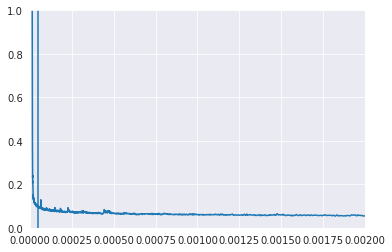

In [41]:
plt.plot(10**lrf.lrs, lrf.losses)
# plt.yscale('log')
plt.ylim(0, 1)
plt.xlim(0, 0.002)
plt.axvline(0.5e-4)

## Google UNet

In [74]:
# https://github.com/DuFanXin/deep_residual_unet/blob/master/res_unet.py
def res_block(x, nb_filters, strides):
    res_path = BatchNormalization()(x)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[0], kernel_size=(3, 3), padding='same', strides=strides[0])(res_path)
    res_path = BatchNormalization()(res_path)
    res_path = Activation(activation='relu')(res_path)
    res_path = Conv2D(filters=nb_filters[1], kernel_size=(3, 3), padding='same', strides=strides[1])(res_path)

    shortcut = Conv2D(nb_filters[1], kernel_size=(1, 1), strides=strides[0])(x)
    shortcut = BatchNormalization()(shortcut)

    res_path = add([shortcut, res_path])
    return res_path

def encoder(x):
    to_decoder = []

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(x)
    main_path = BatchNormalization()(main_path)
    main_path = Activation(activation='relu')(main_path)

    main_path = Conv2D(filters=64, kernel_size=(3, 3), padding='same', strides=(1, 1))(main_path)

    shortcut = Conv2D(filters=64, kernel_size=(1, 1), strides=(1, 1))(x)
    shortcut = BatchNormalization()(shortcut)

    main_path = add([shortcut, main_path])
    # first branching to decoder
    to_decoder.append(main_path)

    main_path = res_block(main_path, [128, 128], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    main_path = res_block(main_path, [256, 256], [(2, 2), (1, 1)])
    to_decoder.append(main_path)

    return to_decoder


def decoder(x, from_encoder):
    main_path = UpSampling2D(size=(2, 2))(x)
    main_path = concatenate([main_path, from_encoder[2]], axis=3)
    main_path = res_block(main_path, [256, 256], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[1]], axis=3)
    main_path = res_block(main_path, [128, 128], [(1, 1), (1, 1)])

    main_path = UpSampling2D(size=(2, 2))(main_path)
    main_path = concatenate([main_path, from_encoder[0]], axis=3)
    main_path = res_block(main_path, [64, 64], [(1, 1), (1, 1)])

    return main_path


def build_res_unet(input_shape):
    inputs = Input(shape=input_shape)

    to_decoder = encoder(inputs)

    path = res_block(to_decoder[2], [512, 512], [(2, 2), (1, 1)])

    path = decoder(path, from_encoder=to_decoder)

    path = Conv2D(filters=1, kernel_size=(1, 1), activation='sigmoid')(path)

    return keras.models.Model(inputs, path)

In [75]:
model = build_res_unet(input_shape=((32, 64, 5,)))

In [77]:
# model.summary()

In [109]:
# Agrawal et al version
def basic_block(x, filters):
    shortcut = x
    x = PeriodicConv2D(filters, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = PeriodicConv2D(filters, kernel_size=3)(x)
    
    shortcut = PeriodicConv2D(filters, kernel_size=3)(shortcut)
    return Add()([x, shortcut])

def downsample_block(x, filters):
    shortcut = x
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = PeriodicConv2D(filters, kernel_size=3)(x)
    
    shortcut = PeriodicConv2D(filters, kernel_size=3, conv_kwargs={'strides': 2})(shortcut)
    return Add()([x, shortcut])

def upsample_block(x, from_down, filters):
    
    x = Concatenate()([x, from_down])
    x = UpSampling2D()(x)
    shortcut = x
    
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = PeriodicConv2D(filters, kernel_size=3)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = PeriodicConv2D(filters, kernel_size=3)(x)
    
    shortcut = PeriodicConv2D(filters, kernel_size=3)(shortcut)
    return Add()([x, shortcut])

def build_unet_google(filters, input_shape, output_channels):
    inputs = x = Input(input_shape)
    x = basic_block(x, filters[0])
    
    # Encoder
    from_down = []
    for f in filters[:-1]:
        x = downsample_block(x, f)
        from_down.append(x)
    
    # Bottleneck
    x = basic_block(x, filters[-1])
    
    # Decoder
    for f, d in zip(filters[:-1][::-1], from_down[::-1]):
        x = upsample_block(x, d, f)
    
    # Final 
    outputs = PeriodicConv2D(output_channels, kernel_size=1)(x)
    
    return keras.models.Model(inputs, outputs)

In [110]:
X, y = dg_train[0]
X.shape, y.shape

((64, 32, 64, 5), (64, 32, 64, 2))

In [111]:
model = build_unet_google(
    filters=[64, 128, 256, 512], 
    input_shape=(32, 64, 5,),
    output_channels=2
)

In [112]:
model.compile('adam', 'mse')

In [113]:
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_25 (InputLayer)           [(None, 32, 64, 5)]  0                                            
__________________________________________________________________________________________________
periodic_conv2d_306 (PeriodicCo (None, 32, 64, 64)   2944        input_25[0][0]                   
__________________________________________________________________________________________________
batch_normalization_250 (BatchN (None, 32, 64, 64)   256         periodic_conv2d_306[0][0]        
__________________________________________________________________________________________________
leaky_re_lu_189 (LeakyReLU)     (None, 32, 64, 64)   0           batch_normalization_250[0][0]    
___________________________________________________________________________________________

In [115]:
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

# plot_model(model, to_file='model.png', show_shapes=True, dpi=200)

In [116]:
from src.clr import LRFinder
import seaborn as sns
sns.set_style('darkgrid')

In [117]:
lrf = LRFinder(
    dg_train.n_samples, batch_size,
    minimum_lr=1e-5, maximum_lr=0.01,
    lr_scale='exp', save_dir='./', verbose=0)

In [118]:
model.fit_generator(dg_train, epochs=1, 
                    callbacks=[lrf])

  ...
    to  
  ['...']
Train for 2191 steps
2191/2191 [==============================] - 212s 97ms/step - loss: 384246291072.0213


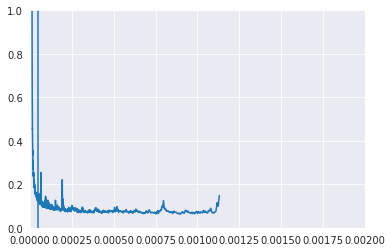

In [119]:
plt.plot(10**lrf.lrs, lrf.losses)
# plt.yscale('log')
plt.ylim(0, 1)
plt.xlim(0, 0.002)
plt.axvline(0.5e-4)